## Bibliotecas e carregamento de arquivo

In [11]:
import pandas as pd
import numpy as np
import re
import requests
import os
from bs4 import BeautifulSoup
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('02-FW.csv')

## Formatação / limpeza

In [12]:
columns = [
        'ID', 'Perfil', 'Nome', 'Nome Completo', 'URL Nome Completo', 'Repetido Nome', 'Posição',
        'Idade', 'Valor de Mercado', 'Nacionalidade', 'URL Clube Antigo', 'Vazio 1', 'URL Clube Antigo Repetido',
        'Vazio 2', 'URL Clube Antigo Repetido 2', 'Clube Antigo', 'URL Liga Antiga', 'Liga Antiga',
        'URL Clube Novo', 'Vazio 3', 'URL Clube Novo Repetido', 'Vazio 4', 'URL Clube Novo Repetido 2',
        'Clube Novo', 'URL Liga Nova', 'Liga Nova', 'Valor Transferência'
    ]
df.columns = columns

# Função para mover os valores para a direita se não houver '/' na coluna 'URL da linha antiga'
def shift_row_if_no_slash(row, col_name):
    # Verifica se não contém '/' na coluna especificada
    if '/' not in str(row[col_name]):
        # Move valores a partir da coluna especificada uma posição à direita
        row.loc[col_name:] = row.loc[col_name:].shift(1)
    return row

df.drop('Vazio 1', axis=1, inplace=True)
df.drop('Vazio 2', axis=1, inplace=True)
df.drop('URL Clube Antigo Repetido', axis=1, inplace=True)
df.drop('URL Clube Antigo Repetido 2', axis=1, inplace=True)

df = df.apply(lambda row: shift_row_if_no_slash(row, 'URL Liga Antiga'), axis=1)

df.drop('Vazio 3', axis=1, inplace=True)
df.drop('Vazio 4', axis=1, inplace=True)
df.drop('URL Clube Novo Repetido', axis=1, inplace=True)
df.drop('URL Clube Novo Repetido 2', axis=1, inplace=True)

df = df.apply(lambda row: shift_row_if_no_slash(row, 'URL Liga Nova'), axis=1)

df.drop('URL Nome Completo', axis=1, inplace=True)
df.drop('Nome Completo', axis=1, inplace=True)
df.drop('Repetido Nome', axis=1, inplace=True)


df['ID'] = df['Perfil'].str.extract(r'/(\d+)$')
df['ID'] = df['ID'].astype(int)

# Filtra as linhas que não contêm 'transfer' ou '?' na coluna 'Valor Transferencia'
df = df[~df['Valor Transferência'].str.contains(r'loan|\?', case=False, na=False)]
df['Valor Transferência'] = df['Valor Transferência'].replace('free transfer', 0)
df['Valor de Mercado'] = df['Valor de Mercado'].replace('-',0)

# Função para converter os valores de string para numéricos
def convert_value(val):
    if isinstance(val, str):
        # Remove o símbolo '€'
        val = val.replace('€', '')
        # Converte valores com 'm' (milhões) para números
        if 'm' in val:
            return float(val.replace('m', '')) * 1000000
        # Converte valores com 'k' (milhares) para números
        elif 'k' in val:
            return float(val.replace('k', '')) * 1000
        # Se for só um número sem 'm' ou 'k', retorna o número como float
        else:
            return float(val)
    return val

# Aplica a função a toda a coluna 'Valor Transferência'
df['Valor Transferência'] = df['Valor Transferência'].apply(convert_value)
# Converte a coluna para tipo numérico, caso ainda tenha algum valor não numérico
df['Valor Transferência'] = pd.to_numeric(df['Valor Transferência'], errors='coerce')

df['Valor de Mercado'] = df['Valor de Mercado'].apply(convert_value)
df['Valor de Mercado'] = pd.to_numeric(df['Valor de Mercado'], errors='coerce')

# Exibe os valores únicos após a conversão
#print(df['Valor Transferência'].unique())
#print(df['Valor Transferência'].describe().apply('{:.2f}'.format))
df['Ano da Tranferência'] = df['URL Clube Antigo'].str.extract(r'.*/(\d+)$')
df.to_csv('02-GK.csv', index=False)

## Gráficos

In [13]:
df.head()

,ID,Perfil,Nome,Posição,Idade,Valor de Mercado,Nacionalidade,URL Clube Antigo,Clube Antigo,URL Liga Antiga,Liga Antiga,URL Clube Novo,Clube Novo,URL Liga Nova,Liga Nova,Valor Transferência,Ano da Tranferência
0,177547,/matheus/profil/spieler/177547,Matheus,Goalkeeper,22,0.0,Brazil,/america-futebol-clube-mg-/startseite/verein/2...,América-MG,/campeonato-brasileiro-serie-b/transfers/wettb...,Série B,/sc-braga/startseite/verein/1075/saison_id/2014,SC Braga,/liga-nos/transfers/wettbewerb/PO1/saison_id/2014,Liga NOS,2400000.0,2014
1,75071,/aranha/profil/spieler/75071,Aranha,Goalkeeper,34,2000000.0,Brazil,/fc-santos/startseite/verein/221/saison_id/2014,Santos,/campeonato-brasileiro-serie-a/transfers/wettb...,Série A,/se-palmeiras-sao-paulo/startseite/verein/1023...,Palmeiras,/campeonato-brasileiro-serie-a/transfers/wettb...,Série A,0.0,2014
2,22412,/julio-cesar/profil/spieler/22412,Júlio César,Goalkeeper,34,1500000.0,Brazil,/queens-park-rangers/startseite/verein/1039/sa...,QPR,/premier-league/transfers/wettbewerb/GB1/saiso...,Premier League,/benfica-lissabon/startseite/verein/294/saison...,Benfica,/liga-nos/transfers/wettbewerb/PO1/saison_id/2014,Liga NOS,0.0,2014
5,19059,/heurelho-gomes/profil/spieler/19059,Heurelho Gomes,Goalkeeper,33,1000000.0,Brazil,/tottenham-hotspur/startseite/verein/148/saiso...,Tottenham,/premier-league/transfers/wettbewerb/GB1/saiso...,Premier League,/fc-watford/startseite/verein/1010/saison_id/2014,Watford,/championship/transfers/wettbewerb/GB2/saison_...,Championship,0.0,2014
6,68727,/vanderlei/profil/spieler/68727,Vanderlei,Goalkeeper,30,900000.0,Brazil,/coritiba-fc/startseite/verein/776/saison_id/2014,Coritiba FC,/campeonato-brasileiro-serie-a/transfers/wettb...,Série A,/fc-santos/startseite/verein/221/saison_id/2014,Santos,/campeonato-brasileiro-serie-a/transfers/wettb...,Série A,0.0,2014


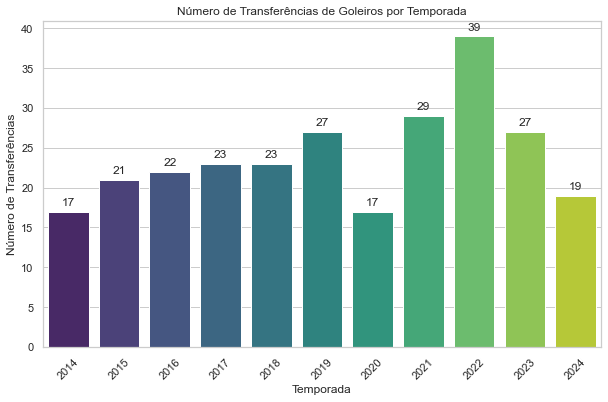

In [18]:
# Agrupamento de dados
agrupado_temp = df.groupby('Ano da Tranferência').size()

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=agrupado_temp.index, y=agrupado_temp.values, palette="viridis")

# Adicionar título e rótulos aos eixos
plt.title('Número de Transferências de Goleiros por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Número de Transferências')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Adicionar os valores em cima de cada barra
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

# Mostrar o gráfico
plt.show()

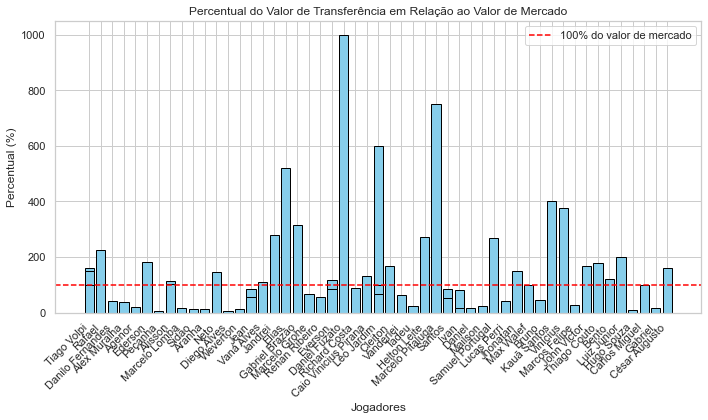

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os casos onde tanto Valor de Transferência quanto Valor de Mercado são diferentes de zero
df_filtrado = df[(df['Valor Transferência'] > 0) & (df['Valor de Mercado'] > 0)].copy()

# Calcular o percentual apenas para os casos válidos
df_filtrado['Percentual Transferência'] = (df_filtrado['Valor Transferência'] / df_filtrado['Valor de Mercado']) * 100

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_filtrado['Nome'], df_filtrado['Percentual Transferência'], color='skyblue', edgecolor='black')
plt.axhline(100, color='red', linestyle='--', label='100% do valor de mercado')  # Linha de referência
plt.xticks(rotation=45, ha='right')
plt.title('Percentual do Valor de Transferência em Relação ao Valor de Mercado')
plt.xlabel('Jogadores')
plt.ylabel('Percentual (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
#df['Percentual Transferência'].describe()
df['Valor Transferência'].describe()
#df['Valor de Mercado'].describe()

count    2.640000e+02
mean     9.813939e+05
std      5.076577e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+05
max      6.250000e+07
Name: Valor Transferência, dtype: float64

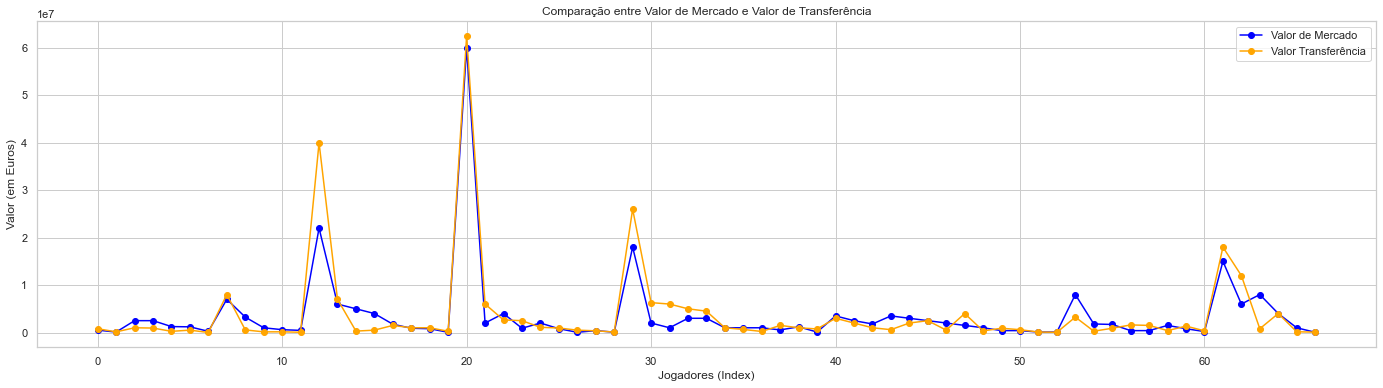

In [15]:
# Filtrar jogadores com valor de mercado e valor de transferência maiores que zero
filtered_df = df[(df['Valor de Mercado'] > 0) & (df['Valor Transferência'] > 0)]

# Criar o vetor de índices para o eixo x
x = range(len(filtered_df))  # Índice para o eixo x

# Criar o gráfico de linha
plt.figure(figsize=(24, 6))
plt.plot(x, filtered_df['Valor de Mercado'], label='Valor de Mercado', marker='o', linestyle='-', color='blue')
plt.plot(x, filtered_df['Valor Transferência'], label='Valor Transferência', marker='o', linestyle='-', color='orange')

# Adicionando título e rótulos
plt.title('Comparação entre Valor de Mercado e Valor de Transferência')
plt.xlabel('Jogadores (Index)')
plt.ylabel('Valor (em Euros)')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_16620\879338728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Diferença'] = filtered_df['Valor Transferência'] - filtered_df['Valor de Mercado']


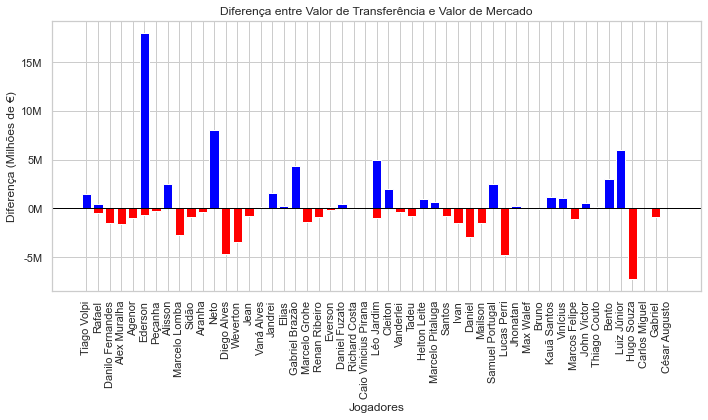

In [16]:
# Passo 1: Calcular a diferença
filtered_df['Diferença'] = filtered_df['Valor Transferência'] - filtered_df['Valor de Mercado']

# Passo 2: Criar o gráfico de barras
plt.figure(figsize=(10, 6))

# Definir as cores: azul para valores positivos e vermelho para negativos
colors = np.where(filtered_df['Diferença'] > 0, 'blue', 'red')

# Plotar o gráfico de barras
plt.bar(filtered_df['Nome'], filtered_df['Diferença'], color=colors)

# Adicionar uma linha horizontal no zero para centralizar o gráfico
plt.axhline(0, color='black', linewidth=1)

# Configurações adicionais de visualização
plt.xticks(rotation=90)
plt.title('Diferença entre Valor de Transferência e Valor de Mercado')
plt.ylabel('Diferença (Milhões de €)')
plt.xlabel('Jogadores')

# Função para formatar o eixo y em milhões
def millions(x, pos):
    return f'{int(x / 1_000_000)}M'

# Aplicar a formatação ao eixo y
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_16620\1701408712.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Valor de Mercado'] = remove_outliers(filtered_df['Valor de Mercado'])
C:\Users\User\AppData\Local\Temp\ipykernel_16620\1701408712.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Valor Transferência'] = remove_outliers(filtered_df['Valor Transferência'])


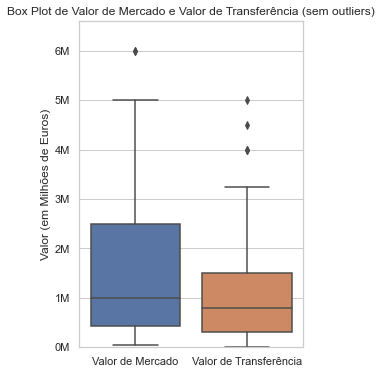

In [17]:
# Filtrar jogadores com valor de mercado e valor de transferência maiores que zero
filtered_df = df[(df['Valor de Mercado'] > 0) & (df['Valor Transferência'] > 0)]

# Função para remover outliers
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= (Q1 - 1.5 * IQR)) & (data <= (Q3 + 1.5 * IQR))]

# Remover outliers
filtered_df['Valor de Mercado'] = remove_outliers(filtered_df['Valor de Mercado'])
filtered_df['Valor Transferência'] = remove_outliers(filtered_df['Valor Transferência'])

# Criar uma figura
plt.figure(figsize=(4, 6))

# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar box plots
sns.boxplot(data=filtered_df[['Valor de Mercado', 'Valor Transferência']])

# Ajustar limites do eixo y
plt.ylim(0, filtered_df[['Valor de Mercado', 'Valor Transferência']].max().max() * 1.1)

# Adicionando título e rótulos
plt.title('Box Plot de Valor de Mercado e Valor de Transferência (sem outliers)')
plt.ylabel('Valor (em Milhões de Euros)')
plt.xticks([0, 1], ['Valor de Mercado', 'Valor de Transferência'])

# Função para formatar o eixo y em milhões
def millions(x, pos):
    return f'{int(x / 1_000_000)}M'

# Aplicar a formatação ao eixo y
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Exibir o gráfico
plt.show()


In [138]:
url_site = "https://www.transfermarkt.us/" ## https://www.transfermarkt.us/Jan-Oblak/leistungsdatendetails/spieler/121483 ## https://www.transfermarkt.us/Jan-Oblak/leistungsdatendetails/spieler/121483/saison/2014/verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1 ## https://www.transfermarkt.us/Jan-Oblak/transfers/spieler/121483/transfer_id/1087965

# Get headers from https://www.whatismybrowser.com/detect/what-http-headers-is-my-browser-sending
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36',
}

In [ ]:
# Definir a função
def get_home(nome_hifen, id):
    url_principal = url_site + str(nome_hifen) + "/leistungsdatendetails/spieler/" + str(id)
    response = requests.get(url_principal, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    print(url_principal)
   
    # Inicializar valores padrão
    date_of_birth = "N/A"
    place_of_birth = "N/A"
    citizenship = "N/A"
    height = "N/A"
    caps = "0"
    goals = "0"

    # Extrai a data de nascimento/idade
    birth_date_elem = soup.find('span', itemprop='birthDate')
    if birth_date_elem:
        date_of_birth = birth_date_elem.get_text(strip=True)

    # Extrai o local de nascimento
    birth_place_elem = soup.find('span', itemprop='birthPlace')
    if birth_place_elem:
        place_of_birth = birth_place_elem.get_text(strip=True)

    # Extrai a cidadania
    citizenship_elem = soup.find('span', itemprop='nationality')
    if citizenship_elem:
        citizenship = citizenship_elem.get_text(strip=True)

    # Extrai a altura
    height_elem = soup.find('span', itemprop='height')
    if height_elem:
        height = height_elem.get_text(strip=True)

    # Extrai Caps/Goals
    highlight_elems = soup.find_all('a', class_='data-header__content--highlight')
    if len(highlight_elems) > 1:
        caps = highlight_elems[0].get_text(strip=True)
        goals = highlight_elems[1].get_text(strip=True)

    # Dados extraídos em uma lista
    data = [
        id,
        nome_hifen,
        date_of_birth,
        place_of_birth,
        citizenship,
        height,
        caps,
        goals
        ]
    return data


In [13]:
def get_stats(nome_hifen, id, ano):
    ano = int(ano) - 1

    url_detalhada = url_site + str(nome_hifen) + "/leistungsdatendetails/spieler/" + str(id) + "/saison/20" + str(ano) + "/verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1"
    response = requests.get(url_detalhada, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    data = []
    print(url_detalhada)
    
    # Encontrar a tabela
    table = soup.find('table', class_='items')

                
    if table:
        # Extrair todas as linhas da tabela
        rows = table.find_all('tr')

        # Inicializar variáveis
        escalado = jogou = ppm = gols_para = gols_contra = entrou = saiu = amarelo = amarelo_duplo = vermelho = gols_tomados = clean_sheets = minutos = "0"

        # Identificar a última linha que contém o texto "Total"
        for row in rows:
            if 'Total' in row.text:
                cols = row.find_all('td')
                if len(cols) > 1:  # Verifique se a linha não está vazia
                    escalado = cols[3].get_text(strip=True)
                    jogou = cols[4].get_text(strip=True)
                    ppm = cols[5].get_text(strip=True)
                    gols_para = cols[6].get_text(strip=True)
                    gols_contra = cols[7].get_text(strip=True)
                    entrou = cols[8].get_text(strip=True)
                    saiu = cols[9].get_text(strip=True)
                    amarelo = cols[10].get_text(strip=True)
                    amarelo_duplo = cols[11].get_text(strip=True)
                    vermelho = cols[12].get_text(strip=True)
                    gols_tomados = cols[13].get_text(strip=True)
                    clean_sheets = cols[14].get_text(strip=True)
                    minutos = cols[15].get_text(strip=True)
    else:
        # Definir todas as variáveis como "0" se a tabela não for encontrada
        escalado = jogou = ppm = gols_para = gols_contra = entrou = saiu = amarelo = amarelo_duplo = vermelho = gols_tomados = clean_sheets = minutos = "0"
                
    # Dados extraídos em uma lista
    data = [
        id,
        ano,
        escalado,
        jogou,
        ppm, 
        gols_para,
        gols_contra,
        entrou,
        saiu,
        amarelo,
        amarelo_duplo,
        vermelho,
        gols_tomados,
        clean_sheets,
        minutos
    ]
    return data    

In [14]:
def get_transfer(nome_hifen, id, tid):
    url_transferencia = url_site + str(nome_hifen) + "/transfers/spieler/" + str(id) + "/transfer_id/" + str(tid)
    response = requests.get(url_transferencia, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    print(url_transferencia)
    
    def get_text_or_empty(element):
        return element.get_text(strip=True) if element else ""

    # Extrair dados relevantes
    transfer_details_div = soup.find("div", class_="box", id=tid)

    # Transfer date and season
    transfer_date_season = get_text_or_empty(transfer_details_div.find("tr", class_="table-highlight").find("td"))
    transfer_date_season = transfer_date_season.replace("Transfer dateSeason", "").strip()
    season, date = transfer_date_season.split(" -")   

    #Ex-clube  +  #Liga do ex-clube
    ex_club = get_text_or_empty(transfer_details_div.find("td", class_="zentriert hauptlink no-border-rechts"))
    ex_club_league = get_text_or_empty(transfer_details_div.find_all("tr")[2].find("td"))
    
    # Novo clube +  # Liga do novo clube
    new_club = get_text_or_empty(transfer_details_div.find("td", class_="zentriert hauptlink no-border-links"))
    new_club_league = get_text_or_empty(transfer_details_div.find_all("tr")[2].find_all("td")[2])
      
    # Encontra todos os <td> com a classe 'zentriert' e colspan '3'
    td_elements = transfer_details_div.find_all('td', class_='zentriert', colspan='3')

    # Percorre os elementos encontrados para verificar o texto interno - Market value at time of transfer
    market_value = None
    for td in td_elements:
        if 'Market value at time of transfer' in td.get_text():
            # Extrai o valor em euro do <td>
            text = td.get_text(strip=True)
            market_value = text.split('€')[-1].strip()
            break

    # Percorre os elementos encontrados para verificar o texto interno - Age at time of transfer
    idade_transfer = None
    for td in td_elements:
        if 'Age at time of transfer' in td.get_text():
            # Extrai a idade na transferencia <td>
            idade_transfer = td.get_text(strip=True)
            idade_transfer = idade_transfer.replace("Age at time of transfer", "").strip()
            break
    
    # Percorre os elementos encontrados para verificar o texto interno - Remaining contract duration at
    contrato_rest = None
    for td in td_elements:
        if 'Remaining contract duration at' in td.get_text():
            # Extrai a idade na transferencia <td>
            contrato_rest = td.get_text(strip=True)
            contrato_rest = contrato_rest.replace("Remaining contract duration at", "").strip()
            contrato_rest = contrato_rest.replace(str(ex_club), "").strip()
            contrato_rest = contrato_rest.split('(')[0].strip()
            break
    
    # Taxa de transferência
    transfer_fee = get_text_or_empty(transfer_details_div.find_all("tr")[-1].find("p", class_="hauptfact"))

    # Dados extraídos em um dicionário
    transfer_data = [
        id,
        tid,
        season,
        date,
        ex_club, 
        ex_club_league,
        new_club,
        new_club_league,
        market_value,
        idade_transfer,
        contrato_rest,
        transfer_fee
    ]
    return transfer_data


In [15]:
from datetime import datetime
# Obtém a hora atual
hora_atual = datetime.now()
hora_formatada = hora_atual.strftime("%H:%M:%S")
print("Hora Inicial:", hora_formatada)

# Definir os nomes das colunas
home_columns = ["ID", "nome_hifen", "data_nasc", "local_nasc", "cidadania", "altura", "convocacoes", "gols_selecao"]
stats_columns = ["ID", "ano_stat", "escalado", "jogou", "ppm", "gols_para", "gols_contra", "entrou", "saiu", "amarelo", "amarelo_duplo", "vermelho", "gols_tomados", "clean_sheets", "minutos"]
transfer_columns = ["ID","tid", "Temporada", "Data", "Ex-clube", "Liga do ex-clube", "Novo_clube", "L_novo_clube", "VdM_epoca", "Idade_transfer", "Duração restante do contrato", "Taxa de transferência"]

df_home = pd.DataFrame(columns=home_columns)
df_stats = pd.DataFrame(columns=stats_columns)
df_transfer = pd.DataFrame(columns=transfer_columns)
print("AGORA VEM O LOOP")

# Loop através de cada linha do DataFrame Id_Temp
for index, row in Nome_Id_Temp.iterrows():
    nome_val = row['Nome'].strip().replace(' ', '-')
    nome_val = nome_val.replace('\'', '')
    nome_val = nome_val.replace('.', '')
    nome_val = unidecode.unidecode(nome_val)
    id_val = row['ID']
    tid_val = row['T_ID']
    ano = row['Temp'].split('/')[0]  # Pegar o ano antes da barra

    
    print(f'\n Dados de {nome_val}')
    lista_home=get_home(nome_val, id_val)
    #print(f'{lista_home}')
    
    lista_stats=get_stats(nome_val, id_val, ano)
    #print(f'{lista_stats}')

    lista_transfer = get_transfer(nome_val, id_val, tid_val)
    #print(f'{lista_transfer}')
    
    # New list for append into df
    df_home.loc[len(df_home)] = lista_home
    df_stats.loc[len(df_stats)] = lista_stats
    df_transfer.loc[len(df_transfer)] = lista_transfer

df_home=df_home.drop_duplicates()
df_stats=df_stats.drop_duplicates()
df_transfer=df_transfer.drop_duplicates()

df_home.to_csv('dados_transferencias_home.csv', index=True)
df_stats.to_csv('dados_transferencias_stats.csv', index=True)
df_transfer.to_csv('dados_transferencias_transfer.csv', index=True)

print("AGORA VEM O merge")
    
# Realizar o merge dos DataFrames
#merged_df = df_home.merge(df_stats, on='ID').merge(df_transfer, on='ID')

# DataFrame final
#merged_df.to_csv('dados_transferencias.csv', index=True)

# Obtém a hora atual
hora_atual = datetime.now()
hora_formatada = hora_atual.strftime("%H:%M:%S")
print("Hora Inicial:", hora_formatada)

Hora Inicial: 16:52:48
AGORA VEM O LOOP

 Dados de Jan-Oblak
https://www.transfermarkt.us/Jan-Oblak/leistungsdatendetails/spieler/121483
https://www.transfermarkt.us/Jan-Oblak/leistungsdatendetails/spieler/121483/saison/2013/verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1
https://www.transfermarkt.us/Jan-Oblak/transfers/spieler/121483/transfer_id/1087965

 Dados de Fraser-Forster
https://www.transfermarkt.us/Fraser-Forster/leistungsdatendetails/spieler/52570
https://www.transfermarkt.us/Fraser-Forster/leistungsdatendetails/spieler/52570/saison/2013/verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1
https://www.transfermarkt.us/Fraser-Forster/transfers/spieler/52570/transfer_id/1107860

 Dados de Marc-Andre-ter-Stegen
https://www.transfermarkt.us/Marc-Andre-ter-Stegen/leistungsdatendetails/spieler/74857
https://www.transfermarkt.us/Marc-Andre-ter-Stegen/leistungsdatendetails/spieler/74857/saison/2013/verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1
https://www.transfermark